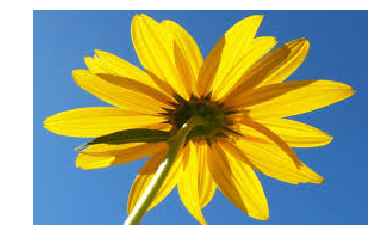

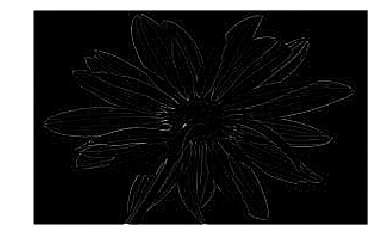

In [2]:
# Ques1 : An edge filter to filter an image
# code referred from
# http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# actual image
actualimage = io.imread('image1.jpg') 
# read the image
image = io.imread('image1.jpg') 
# convert the image to grayscale
image = color.rgb2gray(image)  

# choose a kernel for edge detection
kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

# make a matrix as of image
output = np.zeros_like(image)
# add zero padding to the input image
image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2)) 
image_padded[1:-1, 1:-1] = image

# Loop over every pixel of the image
for x in range(image.shape[1]):     
    for y in range(image.shape[0]):
        # element-wise multiplication of the kernel and the image
        output[y,x]=(kernel*image_padded[y:y+3,x:x+3]).sum()        

# finding the max 
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        output[i][j] = max(output[i][j], 0)

# plot the two images
plt.imshow(actualimage)
plt.axis('off')
plt.show()
plt.imshow(output, cmap=plt.cm.gray)
plt.axis('off')
plt.show()


In [5]:
# Ques 2.1
# Convolutional layer 1
# I have changed step size to 2500 and batch size to 20 to run the program in my machine as my machine is really slow
# I am calculating training and testing accuracy

"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14 * 14 * 32]
  pool1_flat = tf.reshape(pool1, [-1, 14 * 14 * 32])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool1_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2500)

# evaluate training model on train data
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)
  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmprqsvjtdi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E8020D03C8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmprqsvjtdi\model.ckpt.
INFO:tensorflow:loss = 2.284781, s

In [6]:
# Convolution layer 2
# I have changed step size to 2500 and batch size to 20 to run the program in my machine as my machine is really slow


# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2500)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpleajuzvv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E802B4DC88>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpleajuzvv\model.ckpt.
INFO:tensorflow:loss = 2.314168, s

In [7]:
# Question 2.2
# Conv Layer 3
# I have changed step size to 2500 and batch size to 20 to run the program in my machine as my machine is really slow

# Convolution layer 3

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Convolutional Layer #3
  # Computes 128 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 128]
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=128,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #3
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 7, 7, 128]
  # Output Tensor Shape: [batch_size, 3, 3, 128]
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 3, 3, 128]
  # Output Tensor Shape: [batch_size, 3 * 3 * 128]
  pool3_flat = tf.reshape(pool3, [-1, 3 * 3 * 128])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 3 * 3 * 128]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool3_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2500)

# evaluate training model
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('test results')
print(eval_results)
  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpv5btckzm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E802094780>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpv5btckzm\model.ckpt.
INFO:tensorflow:loss = 2.314155, s

In [ ]:
# Results from the above steps
# conv layer 1
train results
{'accuracy': 0.8768, 'loss': 0.48608187, 'global_step': 2500}
Test results
{'accuracy': 0.8866, 'loss': 0.4634487, 'global_step': 2500}

# conv layer 2
train results
{'accuracy': 0.8738, 'loss': 0.5154263, 'global_step': 2500}
test results
{'accuracy': 0.8822, 'loss': 0.49301374, 'global_step': 2500}

# conv layer 3
train results
{'accuracy': 0.7943091, 'loss': 1.0985966, 'global_step': 2500}
test results
{'accuracy': 0.8025, 'loss': 1.0734591, 'global_step': 2500}

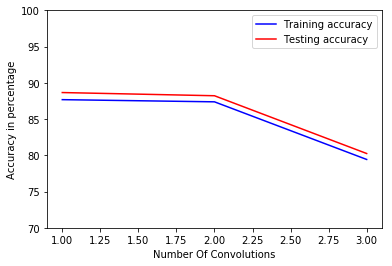

In [37]:
# Ques 2.3
import numpy as np
import pylab 
number_convolution = np.array([1,2,3]);
train_accuracy = np.array([87.68,87.38,79.43]);
test_accuracy = np.array([88.66,88.22,80.25]);

pylab.plot(number_convolution, train_accuracy, '-b', label='Training accuracy')
pylab.plot(number_convolution, test_accuracy, '-r', label='Testing accuracy')
pylab.legend(loc='upper right')
pylab.xlabel('Number Of Convolutions')
pylab.ylabel('Accuracy in percentage')
pylab.ylim(70, 100)
pylab.show()

In [38]:
# Ques 2.4
# 10% noise in labels with convolution layer 2 
# I have used a batch size of 20 and steps as 2000 for my machine as my machine was quite slow
# calculate training and testing accuracies


# Convolution layer 2

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

# introduce 10% noise in sample_train_labels
percent_shuffle = int(sample_train_labels.shape[0] * 0.1)
np.random.shuffle(sample_train_labels[0:percent_shuffle])

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2000)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpq94rrz2f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E80267CDA0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpq94rrz2f\model.ckpt.
INFO:tensorflow:loss = 2.282168, s

In [39]:
# Ques 2.4
# 25% noise in labels with convolution layer 2 
# I have used a batch size of 20 and steps as 2000 for my machine as my machine was quite slow
# calculate training and testing accuracies


# Convolution layer 2

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

# introduce 25% noise in sample_train_labels
percent_shuffle = int(sample_train_labels.shape[0] * 0.25)
np.random.shuffle(sample_train_labels[0:percent_shuffle])

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2000)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpe52g8qis', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E802B4D780>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpe52g8qis\model.ckpt.
INFO:tensorflow:loss = 2.3188398, 

In [40]:
# Ques 2.4
# 50% noise in labels with convolution layer 2 
# I have used a batch size of 20 and steps as 2000 for my machine as my machine was quite slow
# calculate training and testing accuracies


# Convolution layer 2

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

# introduce 50% noise in sample_train_labels
percent_shuffle = int(sample_train_labels.shape[0] * 0.5)
np.random.shuffle(sample_train_labels[0:percent_shuffle])

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2000)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpnejngo9u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E8027219E8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpnejngo9u\model.ckpt.
INFO:tensorflow:loss = 2.3166218, 

In [41]:
# Ques 2.4
# 75% noise in labels with convolution layer 2 
# I have used a batch size of 20 and steps as 2000 for my machine as my machine was quite slow
# calculate training and testing accuracies


# Convolution layer 2

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

# introduce 75% noise in sample_train_labels
percent_shuffle = int(sample_train_labels.shape[0] * 0.75)
np.random.shuffle(sample_train_labels[0:percent_shuffle])

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2000)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmppi3ozn3j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E801E5C5F8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmppi3ozn3j\model.ckpt.
INFO:tensorflow:loss = 2.2798083, 

In [43]:
# Ques 2.4
# 100% noise in labels with convolution layer 2 
# I have used a batch size of 20 and steps as 2000 for my machine as my machine was quite slow
# calculate training and testing accuracies


# Convolution layer 2

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units= num_classes)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

 #  Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

# introduce 100% noise in sample_train_labels
percent_shuffle = int(sample_train_labels.shape[0] * 1.0)
np.random.shuffle(sample_train_labels[0:percent_shuffle])

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=2000)

# evaluate training model on training set
train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
train_results = mnist_classifier.evaluate(input_fn=train_eval_input_fn)
print('train results')
print(train_results)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=20,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Test results')
print(eval_results)

  


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHIPRA~2\\AppData\\Local\\Temp\\tmpwgejt56h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E802682668>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHIPRA~2\AppData\Local\Temp\tmpwgejt56h\model.ckpt.
INFO:tensorflow:loss = 2.3026357, 

In [ ]:
# Results of noise from the above programs
# 10% noise
train results
{'accuracy': 0.7355818, 'loss': 1.2019655, 'global_step': 2000}
Test results
{'accuracy': 0.8211, 'loss': 0.9834665, 'global_step': 2000}

# 25% noise
train results
{'accuracy': 0.59363633, 'loss': 1.8149204, 'global_step': 2000}
Test results
{'accuracy': 0.7674, 'loss': 1.5966333, 'global_step': 2000}
# 50% noise
train results
{'accuracy': 0.33694544, 'loss': 2.2588294, 'global_step': 2000}
Test results
{'accuracy': 0.5808, 'loss': 2.211839, 'global_step': 2000}
# 75% noise
train results
{'accuracy': 0.21030909, 'loss': 2.2779155, 'global_step': 2000}
Test results
{'accuracy': 0.5347, 'loss': 2.2014534, 'global_step': 2000}
# 100% noise
train results
{'accuracy': 0.11089091, 'loss': 2.3013499, 'global_step': 2000}
Test results
{'accuracy': 0.1073, 'loss': 2.2976763, 'global_step': 2000}

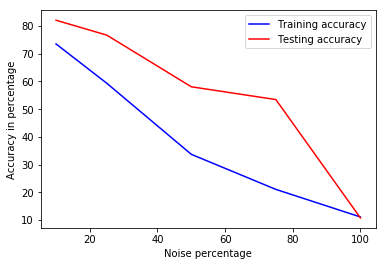

In [45]:
# Ques 2.4
import numpy as np
import pylab 
noise = np.array([10,25,50,75,100]);
train_accuracy = np.array([73.55,59.36,33.69,21.03,11.08]);
test_accuracy = np.array([82.11,76.74,58.08,53.47,10.73]);

pylab.plot(noise, train_accuracy, '-b', label='Training accuracy')
pylab.plot(noise, test_accuracy, '-r', label='Testing accuracy')
pylab.legend(loc='upper right')
pylab.xlabel('Noise percentage')
pylab.ylabel('Accuracy in percentage')
pylab.show()